# Plot Map of Chloroquine Resistance

# Introduction

This notebook recreates Figure 2 from the [Pf7 paper](https://wellcomeopenresearch.org/articles/8-22) - a map of West African sampling locations with levels of Chloroquine resistance plotted as pie charts.


**This notebook should take approximately two minutes to run.**


# Setup

We will use a package called cartopy for making the maps in this notebook. It needs to be installed:

In [1]:
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 103.9 MB/s eta 0:00:00


We also need the malariagen data package to be installed:

In [2]:
!pip install -q --no-warn-conflicts malariagen_data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.5/302.5 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 26.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.8 MB/s eta 0:00:

Import the required python libraries

In [3]:
import pandas as pd
import numpy as np
import collections
import malariagen_data
import warnings
from google.colab import drive

#import plotting libraries
import matplotlib.pyplot as plt
import cartopy
import geopandas

#specifc imports to map and plot samples
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
from collections import Counter
from cartopy.io import shapereader
from time import strftime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
from matplotlib.image import imread

Mount Google Drive to enable saving of the figure

In [6]:
# You will need to authorise Google Colab access to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Access Pf7 Data
We use the malariagen data package to load sample data and metadata

In [4]:
release_data = malariagen_data.Pf7()
sample_metadata = release_data.sample_metadata()

For this figure, we also need to load the inferred drug resistance status classifications.

These are available as a .txt file from a web link. We can use the unix command **wget** to download the file from the web link to our local cloud space.

If you click the left sidebar folder icon, you should see this file appear.

In [5]:
!wget https://www.malariagen.net/sites/default/files/Pf7_inferred_resistance_status_classification.txt

res_class = pd.read_csv('Pf7_inferred_resistance_status_classification.txt', sep="\t") # Read the file in as a pandas dataframe

--2023-09-26 08:46:52--  https://www.malariagen.net/sites/default/files/Pf7_inferred_resistance_status_classification.txt
Resolving www.malariagen.net (www.malariagen.net)... 54.73.5.53, 54.194.205.121
Connecting to www.malariagen.net (www.malariagen.net)|54.73.5.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2173256 (2.1M) [text/plain]
Saving to: ‘Pf7_inferred_resistance_status_classification.txt’

Pf7_inferred_resist 100%[===================>]   2.07M  3.77MB/s    in 0.5s    

2023-09-26 08:46:53 (3.77 MB/s) - ‘Pf7_inferred_resistance_status_classification.txt’ saved [2173256/2173256]



In [7]:
# Take a look at the structure of the drug resistance classification dataframe
res_class.head(3)


,Sample,Chloroquine,Pyrimethamine,Sulfadoxine,Mefloquine,Artemisinin,Piperaquine,SP (uncomplicated),SP (IPTp),AS-MQ,DHA-PPQ,HRP2,HRP3,HRP2 and HRP3
0,FP0008-C,Undetermined,Undetermined,Undetermined,Sensitive,Sensitive,Sensitive,Sensitive,Sensitive,Sensitive,Sensitive,nodel,nodel,nodel
1,FP0009-C,Resistant,Resistant,Sensitive,Sensitive,Sensitive,Sensitive,Resistant,Sensitive,Sensitive,Sensitive,nodel,nodel,nodel
2,FP0010-CW,Undetermined,Resistant,Resistant,Sensitive,Sensitive,Sensitive,Resistant,Sensitive,Sensitive,Sensitive,uncallable,uncallable,uncallable


You can see that this file contains a sample identifier, followed by information on the resistance of that sample to different antimalarial treatments.

### Drug resistance in *P. falciparum*

For the [Pf7 paper](https://wellcomeopenresearch.org/articles/8-22/v1) samples were classified as resistant or sensitive to major antimalarials and combinations based on genotyping of known drug resistance alleles. The full list of alleles used for this analysis is found in Table 2 of the paper. A full explanation of the methods for this classification process is detailed [here](https://www.malariagen.net/sites/default/files/Pf7_resistance_classification.pdf).

The figure created by this notebook covers Chloroquine resistance. Samples in Pf7 were classified according to their *crt* genotype at codon 76:
 - **K** = Sensitive
 - **T** = Resistant
 - **K/T** heterozygote = Undetermined
 - **missing** = Undetermined
 - **other mutation** = Undetermined

For more information on the drug chloroquine, you can [read here](https://en.wikipedia.org/wiki/Chloroquine)

# Combine data into a single dataframe
In order to create the final figure it is easier to have all relevant data combined.

For the final figure we need to keep:
- All samples from sample_metadata which pass QC (n = 16,203)
- Columns 2 to 9 from the res_class dataframe (these contain the drug resistance classifications)

In [8]:
# Filter sample metadata to include only QC pass samples
sample_metadata_qcpass = sample_metadata[sample_metadata['QC pass'] == True]
sample_metadata_qcpass.shape

(16203, 17)

In [9]:
# Trim res_class down to only relevant columns
res_class_trim = res_class.iloc[:, 0:9] # We keep the sample ID column to allow us to merge with sample_metadata using this information

In [10]:
# Merge the two dataframes on identical Sample IDs
df_all_sample_metadata = pd.merge(
    left = sample_metadata_qcpass,
    right = res_class_trim,
    left_on = 'Sample',
    right_on = 'Sample',
    how = 'inner')

# View the new dataframe stucture
df_all_sample_metadata.head(3)

,Sample,Study,Country,Admin level 1,Country latitude,Country longitude,Admin level 1 latitude,Admin level 1 longitude,Year,ENA,...,Sample type,Sample was in Pf6,Chloroquine,Pyrimethamine,Sulfadoxine,Mefloquine,Artemisinin,Piperaquine,SP (uncomplicated),SP (IPTp)
0,FP0008-C,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR1081237,...,gDNA,True,Undetermined,Undetermined,Undetermined,Sensitive,Sensitive,Sensitive,Sensitive,Sensitive
1,FP0009-C,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR1081238,...,gDNA,True,Resistant,Resistant,Sensitive,Sensitive,Sensitive,Sensitive,Resistant,Sensitive
2,FP0010-CW,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR2889621,...,sWGA,False,Undetermined,Resistant,Resistant,Sensitive,Sensitive,Sensitive,Resistant,Sensitive


# Figure plotting setup

Here we define a few items which will help us to plot the Chloroquine figure.

In [11]:
# Firstly, a list named 'drugs' which lists the antimalarial treatment types from our combined dataframe
# this leaves open the option of investigating other drugs should we be interested in doing that in the future.
drugs = [
    'Chloroquine',
    'Pyrimethamine',
    'Sulfadoxine',
    'Mefloquine',
    'Artemisinin',
    'Piperaquine',
    'SP (uncomplicated)',
    'SP (IPTp)',
]

In [12]:
# Secondly, an ordered dictionary which maps the codes for major sub-populations to the full name of the major sub-population.
# We choose an ordered dictionary, rather than a regular python dictionary, to keep the order of our subpopulations from west to east.
populations = collections.OrderedDict()
populations['SA'] = 'South America'
populations['AF-W'] = 'West Africa'
populations['AF-C'] = 'Central Africa'
populations['AF-NE'] = 'Northeast Africa'
populations['AF-E'] = 'East Africa'
populations['AS-SA-W'] = 'Western South Asia'
populations['AS-SA-E'] = 'Eastern South Asia'
populations['AS-SEA-W'] = 'Western Southeast Asia'
populations['AS-SEA-E'] = 'Eastern Southeast Asia'
populations['OC-NG'] = 'Oceania'

In [13]:
# Finally, an ordered dictionary which maps the codes for major sub-populations to a colour code.
# This ordered dictionary preserves the order of the subpopulations in the previous code block
population_colours = collections.OrderedDict()
population_colours['SA']       = "#4daf4a"
population_colours['AF-W']     = "#e31a1c"
population_colours['AF-C']     = "#fd8d3c"
population_colours['AF-NE']    = "#bb8129"
population_colours['AF-E']     = "#fecc5c"
population_colours['AS-SA-W']  = "#dfc0eb"
population_colours['AS-SA-E']  = "#984ea3"
population_colours['AS-SEA-W'] = "#9ecae1"
population_colours['AS-SEA-E'] = "#3182bd"
population_colours['OC-NG']    = "#f781bf"


# Create data summaries
These will be used to build the final figure

### 1. Aggregation functions
Here we define two functions **proportion_agg** and **n_agg**.

Proportion_agg summarises the proportion of samples listed as 'Resistant' out of all samples which are listed as either 'Sensitive' or 'Resistant' - i.e. not 'Undetermined'. It returns a pandas series object with this information.

n_agg does the same but for the counts, rather than proportions.

In [14]:
def proportion_agg(x):
    names = collections.OrderedDict() # create an empty ordered dictionary
    for drug in drugs: # Loop over each drug type
        n = np.count_nonzero( (x[drug] != 'Undetermined') ) # Count how many entries are not 'Undetermined'
        if n == 0:
            proportion = np.nan # Assign nan if none
        else:
            proportion = np.count_nonzero( # Otherwise, calculate the proportion of samples which are 'Resistant'
                ( x[drug] == 'Resistant')
            ) / np.count_nonzero(
                ( x[drug] != 'Undetermined' )
            )

        names[drug] = proportion
    return pd.Series(names)

def n_agg(x):
    names = collections.OrderedDict()
    for drug in drugs:
        n = np.count_nonzero( (x[drug] != 'Undetermined') )
        names[drug] = n
    return pd.Series(names)


### 2. Data filtering and summaries

Here we create further data subsets and summaries to help with plotting the final figure.

In [15]:
# Define some limits on which samples are going to be included
min_year=2013
max_year=2016
location=['AF-W']
drug='Chloroquine'
min_n = 25 # This is the minimum number of samples needed with an unambiguous inferred drug resistance phenotype

In [16]:
# Create a new dataframe which includes only samples which meet the year range specified previously
df = df_all_sample_metadata.loc[
        df_all_sample_metadata['QC pass'] # Also only include samples passing QC
        & ( df_all_sample_metadata['Year'].astype(int) >= min_year )
        & ( df_all_sample_metadata['Year'].astype(int) <= max_year )
    ].copy()

df['Year group'] = f"{min_year}-{max_year}" # Create a new column for year group in the new dataframe

# Filter the dataframe by location criteria specified above
for i, loc in enumerate(location):
    if i == 0:
        df = df.loc[df['Population'] == loc]
    if i == 1:
        df = df.loc[df['Country'] == loc]
    if i == 2:
        df = df.loc[df['Admin level 1'] == loc]

In [17]:
# Create a dataframe for the sample frequencies of this new filtered dataframe 'df' using the function 'proportion_agg'
df_freqs = (
    pd.DataFrame(
        df
        .groupby(['Admin level 1 longitude', 'Country', 'Admin level 1', 'Year group'])
        .apply(proportion_agg)[drug]
    ).reset_index()
)

# Create a dataframe for the sample counts of this new filtered dataframe 'df' using the function 'n_agg'
df_n = (
    pd.DataFrame(
        df
        .groupby(['Admin level 1 longitude', 'Country', 'Admin level 1', 'Year group'])
        .apply(n_agg)[drug]
    ).reset_index()
)

# Create a new column for Location which includes info on the location but also the sample counts per location
df_freqs['Location'] = df_n.apply(lambda row: f"{row['Admin level 1']}, {row['Country']} ($n$={row['Chloroquine']})", axis=1)

# Filter the 'Location' and resistance proportion data based on a condition where the count of 'Chloroquine' is at least the previously specified minimum count (25).
locations = df_freqs['Location'][df_n['Chloroquine'] >= min_n]
resistance_proportions = df_freqs['Chloroquine'][df_n['Chloroquine'] >= min_n]



View the West African locations for which we have at least 25 samples with an unambiguous chloroquine resistance classification.

In [18]:
locations

0                 Dakar, Senegal ($n$=83)
1               Western, Gambia ($n$=141)
2               Sedhiou, Senegal ($n$=56)
3           Upper River, Gambia ($n$=372)
5                   Kayes, Mali ($n$=217)
6     Hodh el Gharbi, Mauritania ($n$=27)
7                  Bamako, Mali ($n$=133)
8               Koulikoro, Mali ($n$=441)
10                 Sikasso, Mali ($n$=27)
12        Abidjan, Côte d'Ivoire ($n$=63)
14               Ashanti, Ghana ($n$=263)
15                Central, Ghana ($n$=91)
16            Upper East, Ghana ($n$=757)
17          Greater Accra, Ghana ($n$=27)
18                  Volta, Ghana ($n$=41)
19             Atlantique, Benin ($n$=44)
20              Littoral, Benin ($n$=100)
22          Sud-Ouest, Cameroon ($n$=193)
23            Wouleu-Ntem, Gabon ($n$=47)
Name: Location, dtype: object

# Plot the figure

### Load map images

In [19]:
# First we need to download the map image file via a web link:
!wget https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/raster/NE1_50M_SR_W.zip

--2023-09-26 08:47:59--  https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/raster/NE1_50M_SR_W.zip
Resolving www.naturalearthdata.com (www.naturalearthdata.com)... 50.87.253.14
Connecting to www.naturalearthdata.com (www.naturalearthdata.com)|50.87.253.14|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://naciscdn.org/naturalearth/50m/raster/NE1_50M_SR_W.zip [following]
--2023-09-26 08:48:00--  https://naciscdn.org/naturalearth/50m/raster/NE1_50M_SR_W.zip
Resolving naciscdn.org (naciscdn.org)... 18.160.46.70, 18.160.46.106, 18.160.46.110, ...
Connecting to naciscdn.org (naciscdn.org)|18.160.46.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88413091 (84M) [application/zip]
Saving to: ‘NE1_50M_SR_W.zip’

NE1_50M_SR_W.zip    100%[===================>]  84.32M  35.9MB/s    in 2.4s    

2023-09-26 08:48:03 (35.9 MB/s) - ‘NE1_50M_SR_W.zip’ saved [88413091/88413091]



In [20]:
# Unzip the file and define the path to the image file:
!unzip './NE1_50M_SR_W.zip'
image = './NE1_50M_SR_W/NE1_50M_SR_W.tif'

Archive:  ./NE1_50M_SR_W.zip
   creating: NE1_50M_SR_W/
  inflating: NE1_50M_SR_W/NE1_50M_SR_W.tfw  
  inflating: NE1_50M_SR_W/NE1_50M_SR_W.tif  
  inflating: NE1_50M_SR_W/Read_me.txt  


### The main plot commands

In [21]:
# Set the figure resolution - higher values = higher resolution
plt.rcParams['figure.dpi'] = 200
fig = plt.figure()

<Figure size 1280x960 with 0 Axes>

In [22]:
# Create a list of dictionaries 'location_coords'
# This list stores information for each location in the plot:
# annotation_ha sets the alignment of the pie chart with a location
# x/y_offsets set how far off the centre alignment the pie chart will appear
# pie_lon, pie_lat set the coordinates of each pie chart
# connection_style sets the connector line

# Note that here the administrative divisions are hard coded - i.e. written out rather than linked to a variable
# If you were to investigate a different region, you may need to re-write these names according to
# what is contiained within the 'locations' variable, as well as tweaking the other values
# to suit your new map

locations_coords = [
        dict(location = ('Dakar'), annotation_ha='center' ,         x_offset=-2 , y_offset=1.5, pie_lon=-0.7071, pie_lat=0.7071, connection_style = "arc3,rad=0."),
        dict(location = ('Western'), annotation_ha='center' ,       x_offset=-2 , y_offset=-1.5, pie_lon=-1, pie_lat=0, connection_style ="arc3,rad=0."),
        dict(location = ('Sedhiou'), annotation_ha='center' ,       x_offset=-0.5 , y_offset=-2.2, pie_lon=-0.7071, pie_lat=-0.7071, connection_style ="arc3,rad=0."),
        dict(location = ('Upper River'), annotation_ha='center',    x_offset=0 , y_offset=2.5, pie_lon=0, pie_lat=1, connection_style ="arc3,rad=0."),
        dict(location = ('Kayes') , annotation_ha='center',         x_offset=-1.5 , y_offset=-2.0, pie_lon=-0.7071, pie_lat=-0.7071, connection_style ="arc3,rad=-0."),
        dict(location = ('Hodh el Gharbi'), annotation_ha='center', x_offset=3.2 , y_offset=0, pie_lon=1, pie_lat=0, connection_style ="arc3,rad=-0."),
        dict(location = ('Bamako'), annotation_ha='center' ,        x_offset=-1.5 , y_offset=-2, pie_lon=-0.7071, pie_lat=-0.7071, connection_style ="arc3,rad=-0."),
        dict(location = ('Koulikoro'), annotation_ha='center' ,     x_offset=2.5 , y_offset=0.8, pie_lon=0.7071, pie_lat=0.7071, connection_style ="arc3,rad=-0."),
        dict(location = ('Sikasso'),annotation_ha='center' ,        x_offset=0 , y_offset=-2.5, pie_lon=0, pie_lat=-1, connection_style ="arc3,rad=0."),
        dict(location = ('Abidjan'), annotation_ha='center' ,       x_offset=-3 , y_offset=0, pie_lon=-1, pie_lat=0, connection_style ="arc3,rad=0."),
        dict(location = ('Ashanti'), annotation_ha='center' ,       x_offset=-2.2 , y_offset=1, pie_lon=-0.7071, pie_lat=0.7071, connection_style ="arc3,rad=0."),
        dict(location = ('Central'),annotation_ha='center' ,        x_offset=-2 , y_offset=-2, pie_lon=-0.7071, pie_lat=-0.7071, connection_style ="arc3,rad=0."),
        dict(location = ('Upper East'), annotation_ha='center' ,    x_offset=0 , y_offset=2.5, pie_lon=0, pie_lat=1, connection_style ="arc3,rad=0."),
        dict(location = ('Greater Accra'), annotation_ha='center' , x_offset=0 , y_offset=-2.5, pie_lon=0, pie_lat=-1, connection_style ="arc3,rad=0."),
        dict(location = ('Volta'),annotation_ha='center' ,          x_offset=0 , y_offset=2.3, pie_lon=0, pie_lat=1, connection_style ="arc3,rad=0."),
        dict(location = ('Atlantique'), annotation_ha='center' ,    x_offset=2 , y_offset=2, pie_lon=0.7071, pie_lat=0.7071, connection_style ="arc3,rad=-0."),
        dict(location = ('Littoral'), annotation_ha='center' ,      x_offset=2 , y_offset=-2, pie_lon=0.7071, pie_lat=-0.7071, connection_style ="arc3,rad=-0."),
        dict(location = ('Sud-Ouest'),annotation_ha='center' ,      x_offset=0 , y_offset=2.5, pie_lon=0, pie_lat=1, connection_style ="arc3,rad=0."),
        dict(location = ('Wouleu-Ntem'),annotation_ha='center' ,    x_offset=-2 , y_offset=1, pie_lon=0, pie_lat=1, connection_style ="arc3,rad=-0."),
]

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


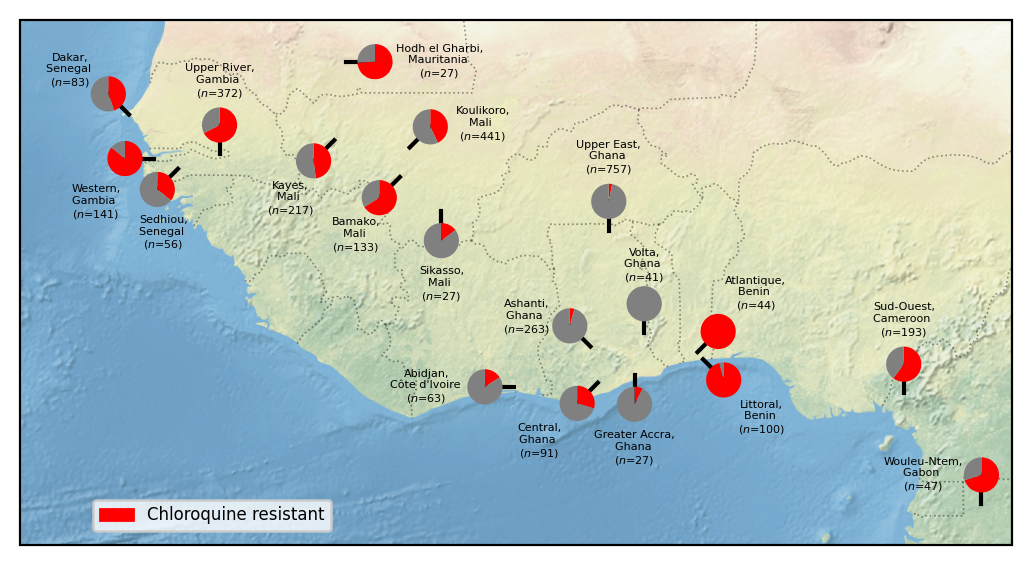

In [23]:
# The final function for plotting

# Set up the plot axes using a Plate Carrée projection
# A Plate Carrée projection sets lines of latitude and longitude
# to be represented as equally spaced horizontal and vertical lines
ax = plt.axes(projection=ccrs.PlateCarree())
ax.imshow(imread(image), origin='upper', transform= ccrs.PlateCarree(),
          extent=[-180, 180, -90, 90])
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.6, alpha=0.4) # This adds border lines between countries

# Note the first time you run this code, Cartopy gives a DownloadWarning which
# lets you know an image is read from a URL. You do not need to worry about this warning.

# Make a new dataframe 'proportion_resistant' which sets a new index and drops the old index
proportion_resistant = resistance_proportions.reset_index(drop = True)

# Iterate over locations
for n, loc in enumerate(locations):
    adm1 = loc.split(',')[0] # Save the part of the 'loc' string occuring before the comma ',' as adm1

    # Extract latitude and longitude for the location
    lat = np.unique(df_all_sample_metadata.loc[df_all_sample_metadata['Admin level 1'] == adm1]['Admin level 1 latitude'])
    lon = np.unique(df_all_sample_metadata.loc[df_all_sample_metadata['Admin level 1'] == adm1]['Admin level 1 longitude'])

    # Define the function 'plot_pie' to make a pie chart per location
    # This function takes parameters including the proportion of resistant samples,
    # The location coordinates (lon, lat)
    # ax = location on larger map of West Africa
    # width, height = size of pie chart
    def plot_pie(proportion_resistant,lon,lat,ax,width,height):
        ax_sub = inset_axes(
            ax, width, height, loc=10,
            bbox_to_anchor=(lon + locations_coords[n]['pie_lon'], lat + locations_coords[n]['pie_lat']),
            bbox_transform=ax.transData,
            borderpad=0
        )
        # Set colours for the pie chart
        wedges,texts= ax_sub.pie(proportion_resistant, colors = ['red', 'grey'], radius=2.75, startangle=90, counterclock=False)

        # Set the line connector between pie chart and location
        ax.plot(
            [lon, lon + locations_coords[n]['pie_lon']]
            , [lat, lat + locations_coords[n]['pie_lat']]
            , color='black'
        )
        # Set annotations for the pie chart
        ax.annotate(loc.split(', ')[0] + ',\n' + loc.split(', ')[1].split('(')[0] + '\n(' + loc.split('(')[1],
                    xy=(lon, lat),
                    xycoords='data',
                    xytext=(
                        lon + locations_coords[n]['x_offset'],
                        lat + locations_coords[n]['y_offset']
                    ),
                    textcoords='data',
                    fontsize=4,
                    ha = locations_coords['location' == adm1]['annotation_ha'],
                    va = 'center'
                    )
    plot_pie([proportion_resistant[n],1-proportion_resistant[n]],lon,lat,ax,.08,.08)

# Set final plot axes limits
ax.set_xlim(-21, 13)
ax.set_ylim(0, 18)

# Set a legend
red_patch = mpatches.Patch(color='red', label='Chloroquine resistant')
plt.legend(handles=[red_patch],loc=(-55,-3),prop={'size': 6})

# This will send the file to your Google Drive, where you can download it from if needed
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else
file_path = '/content/drive/My Drive/'
file_name = 'map_waf_chloroquine'

# We save as both .png and .PDF files
plt.savefig(f'{file_path}{file_name}.png', dpi=240, bbox_inches="tight")
plt.savefig(f'{file_path}{file_name}.pdf')

plt.show()

**Figure legend**: Heterogenity of chloroquine resistance in west Africa. Inferred resistance levels to chloroquine between 2013 and 2016 in different administrative divisions within West Africa. We only include locations for which we have at least 25 samples with an unambiguous inferred chloroquine resistance phenotype. Note the very different chloroquine resistance profiles in nearby locations, e.g. Volta, Ghana vs Atlantique, Benin.